# Spotify recommendation using MinHashing and Gaussian Mixture Models

## Group Members: Kaile Suoo, Jerry Li, Tawhid Ather

## Description

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.sparse import csr_matrix
import statsmodels.api as sm
import json

## Dataset

In [2]:
# only read in necessary features from dataset into csv file and put into dataset
playlists = []
for i in range(0, 1000000, 1000):
    with open(f'./data/data/mpd.slice.{i}-{i+999}.json', 'r') as file:
        data = json.load(file)
        
        for playlist in data['playlists']:
            playlists.append({
                'pid': playlist['pid'],
                'name': playlist['name'],
                'tracks': [track['track_uri'] for track in playlist['tracks']], 
            })
df = pd.DataFrame(playlists)

In [3]:
df

,pid,name,tracks
0,0,Throwbacks,"[spotify:track:0UaMYEvWZi0ZqiDOoHU3YI, spotify..."
1,1,Awesome Playlist,"[spotify:track:2HHtWyy5CgaQbC7XSoOb0e, spotify..."
2,2,korean,"[spotify:track:74tqql9zP6JjF5hjkHHUXp, spotify..."
3,3,mat,"[spotify:track:4WJ7UMD4i6DOPzyXU5pZSz, spotify..."
4,4,90s,"[spotify:track:4iCGSi1RonREsPtfEKYj5b, spotify..."
...,...,...,...
999995,999995,Praise,"[spotify:track:2AMSWGnT7NCvOAPXxuRxIh, spotify..."
999996,999996,Worship,"[spotify:track:2vr3TRf7tH7dfrUp9noq5u, spotify..."
999997,999997,Sex,"[spotify:track:1sQrCwV8vvtYLqa0KQlwE9, spotify..."
999998,999998,✝️,"[spotify:track:5Mw9bXG1dLNhbjofkVS2oR, spotify..."


In [4]:
unique_tracks = set()
for tracks in df['tracks']:
    unique_tracks.update(tracks)

track_idx = {}
idx_track = {}
for idx, track in enumerate(unique_tracks):
    track_idx[track] = idx
    idx_track[idx] = track

playlist_idx = {}
idx_playlist = {}
for idx, playlist in enumerate(df['pid']):
    playlist_idx[playlist] = idx
    idx_playlist[idx] = playlist

n_playlists = len(df)
n_tracks = len(unique_tracks)

n_playlists, n_tracks

(1000000, 2262292)

## MinHashing

Find the k-most similar playlists to any given playlist.

Estimate Jaccard Similarity between the million playlists to find the ones most similar to each other.

Resources: 


In [5]:
row = []
col = []
data = []

for idx, tracks in enumerate(df['tracks']):
    for track in tracks:
        row.append(track_idx[track])
        col.append(idx)
        data.append(1)

dfC = csr_matrix((data, (row, col)), shape=(len(unique_tracks), len(df)))

In [6]:
def minhash(nhash, dfC, Phash): #take given char matrix, nhash, and flesh it out.
    '''
    Takes a number of hash functions to use (nhash) and characteristic matrix (dfC)
    '''
    # use the "universal hash":  (a*x+b) mod p, where a, b are random ints and p > N is prime
    np.random.seed(4022)
    
    Phash = Phash #phash *MUST* be >len(dFC)
    Ahash = np.random.choice(range(0,Phash), size=nhash)
    Bhash = np.random.choice(range(0,Phash), size=nhash)

    # STEP 2:  initialize signature matrix to all infinities
    Msig = np.full([nhash, dfC.shape[1]], fill_value=np.inf)

    # fill in the signature matrix:
    # For each row of the characteristic matrix... 
    hash_vals = [0]*nhash # initialize
    for r in range(dfC.shape[0]):
        # STEP 3:  Compute hash values (~permuted row numbers) for that row under each hash function
        hash_vals = (Ahash * r + Bhash) % Phash
        # STEP 4:  For each column, if there is a 0, do nothing...
            # ... but if there is a 1, replace signature matrix element in that column for each hash fcn 
            # with the minimum of the hash value in this row, and the current signature matrix element
        c = dfC[r].nonzero()[1]
        for h in range(nhash):
            Msig[h, c] = np.minimum(Msig[h, c], hash_vals[h])
    return Msig

In [7]:
nhash = 100
Phash = 2500009

Msig = minhash(nhash, dfC, Phash)

In [8]:
# computing entire similarity matrix is computationally expensive, so only compute for the playlist we're interested in making recommendations for
def get_k_similar_playlists(Msig, playlist_idx, k):
    sims = []
    for i in range(Msig.shape[1]):
        if i == playlist_idx:
            sims.append(-1)
        else:
            sims.append(np.sum(Msig[:, playlist_idx] == Msig[:, i]) / Msig.shape[0])

    similar = {}
    for i in range(k):
        temp = np.argmax(sims)
        similar[temp] = sims[temp]
        sims[temp] = 0

    return similar

In [9]:
# example for if we wanted to find the 20 most similar songs to the playlist at index 0
idx = 0
k = 20
similar = get_k_similar_playlists(Msig, idx, k)

print(k, 'most similar to', df.iloc[idx]['name'])
for idx, sim in similar.items():
    print(df.iloc[idx]['name'], ':', sim)

20 most similar to Throwbacks
throwbacks : 0.24
oldies but goodies : 0.22
2000s : 0.21
90's : 0.21
Throwbacks : 0.2
2000s : 0.2
nice : 0.19
Throwbacks : 0.19
Throwbacks : 0.19
Throwback : 0.19
Nostalgia : 0.19
Throwbacks : 0.19
throwback  : 0.19
Throwback : 0.19
throwbacks : 0.18
throwback : 0.18
Throw It Back : 0.18
Throw Back : 0.18
Throwbacks : 0.18
tb : 0.18


## GMM

Cluster songs within the k most similar playlists and recommend based on probabilities.

In [15]:
tracks_data = pd.read_csv('./data/tracks_data.csv')

In [16]:
track_ids = set()
for playlist_idx in similar:
    for track in playlists[playlist_idx]['tracks']:
        filtered = track.replace('spotify:track:', '')
        track_ids.add(filtered)
#track_ids

dat = tracks_data[tracks_data['id'].isin(track_ids)]
dat.reset_index(drop=True, inplace=True)
dat

input_songs_indices = set()
for song in playlists[idx]['tracks']:
    filtered = song.replace('spotify:track:', '')
    if filtered in dat.values:
        index = dat.index[dat['id'] == filtered]
        input_songs_indices.add(index[0])

In [17]:
GMM_DROP = ['id', 'name', 'tempo']
dat1 = dat.drop(columns=GMM_DROP)
dat1

,danceability,energy,loudness,speechiness,acousticness,liveness,valence
0,0.481,0.940,-5.204,0.0660,0.000891,0.0939,0.660
1,0.677,0.965,-2.355,0.0426,0.093100,0.3450,0.749
2,0.847,0.843,-3.579,0.1060,0.415000,0.1070,0.963
3,0.778,0.824,-5.892,0.0712,0.284000,0.4050,0.756
4,0.380,0.988,-2.042,0.0639,0.000026,0.3680,0.769
...,...,...,...,...,...,...,...
532,0.705,0.796,-6.845,0.2670,0.070800,0.3880,0.864
533,0.647,0.715,-5.613,0.0430,0.014900,0.1410,0.561
534,0.463,0.901,-4.073,0.0870,0.007790,0.3200,0.621
535,0.398,0.945,-7.535,0.0700,0.012800,0.1710,0.534


In [ ]:
def GMM(dat, k, dimension):
    
    #Comments will reference slides 26-31 from Feb 9:
    
    """Define the variables we will use in the Algorithm"""
    #This represents W_m (weights/likelihood of each component) (slide 26)
    p_class=np.zeros(k)
    
    #This represents μ_m (mean values of each component) (slide 26)
    means=np.zeros((k,dimension))
    
    #This represents Σ_m (covariance matrix) (slide 26)
    covars=np.zeros((k,dimension,dimension))
    
    #This represets p̃_mi (slide 27)
    p_data_given_class=np.zeros((len(dat),k))

    #This is just used at the end to compute mean dist
    mean_dist=np.array(0)
    
    #initializations of initial points (used to set the initial menas lower down)
    init_idx=np.random.choice(range(len(dat)), size=k, replace=False)
    #print("INIT_IDX: {}".format(init_idx))
    
    """Initialize means, covs, p_classes"""
    #Initialize the covariance matrix, the means, and the p_class for each of k components (dims)
    for dim in range(k):
        #Set the cov matrix of each component to the cov of the entire dataset (slide 26)
        covars[dim,:,:]=np.cov(np.transpose(dat))

        #Set initial means to initial chosen data points (slide 26)
        means[dim,:]=dat.iloc[init_idx[dim]]
        
        #Give each component equal weighting / likelihood to start (slide 26)
        p_class[dim]=1/k    
    
    #Now we start our for loop, where-in we'll alernate between: (1) Expecation Step and (2) Maximization Step
    for step in range(50):  
        """Expectation Step (Slide 27)"""
        #Bayes stuff: pdfs then pdf*mixtures, then normalize
        
        #For each class (component), compute prob data given class slide 27)
        for dim in range(k):
            #Use pdf to get prob of each data point given component (dim) (slide 27)
            p_data_given_class[:,dim] = stats.multivariate_normal.pdf(x=dat, mean=means[dim], cov=covars[dim])

            #What we have now is P(x_i | cluster = m). We still need to multiply by P(cluster = m)
            
        #Multiply by p_class (slide 27)
        p_class_given_data=p_data_given_class*p_class

        #Now consolidate into probabilities using 1/α_i (slide 27)
        sums=np.sum(p_class_given_data, axis=1)

        for dim in range(k):
            #For each class, divide by the sum to convert to probabilities (slide 27)
            #p_class_given_data now represents p̂_mi
            p_class_given_data[:,dim]=p_class_given_data[:,dim]*(1/sums)
            
        #Now we have completed everything in the Expectation step (slide 27). We'll move on to the maximization step

        """Maximization Step (Slide 29-30)"""
        #We'll count the number of points in each component (will be fractional, not whole #)
        #n_class represents n̂_m (Slide 30)
        n_class = np.sum(p_class_given_data, axis=0)

        #Now, we re-compute p_class (which represents W_m, or the weight/likelihood of each class)
        #(See first bullet pt on slide 30)
        p_class=n_class/len(dat)

        #Now we need to do the mean and covariance updates (slide 30)
        for dim in range(k):
            #To compute new means within each class/component (slide 30 bullet pt. 2)
            #1. Sum across: (p_class_given_data * data) = (p̂_mi * x_i)
            #2. Divide by n_class (n̂_m)
            for i in range(dimension):
                means[dim, i] = np.sum(p_class_given_data[:, dim] * dat.iloc[:, i]) / n_class[dim]
            
            #Now we update the variance/covariance Σ_m by weighted sample covariance (slide 30 bullet pt. 3)
            #Make a copy of the data, then subtract the new means
            X_new=dat.copy()
            X_new = dat - means[dim]
                        
            #We can compute the covar matrix for each component as below (slide 30 bullet pt. 3):
            #1. First we'll take the transpose of our new "centered" data (X_new)
            #2. Then we multiply that by our p_class_given_data (p̂_mi)
            #3. Next we do a matrix multiplication between our result from step 2 and X_new (mean centered data)
            #4. Last, we divide by n_class (n̂_m)
            
            covars[dim,:,:]=np.matmul((np.asarray(X_new).T)*(p_class_given_data[:,dim]),X_new)/(n_class[dim])                                                    

    #Once we're done with our for loop, we compute the mean dist (This formula is given below in Part B):
    mean_dist=0
    for pt in range(len(dat)):
        for dim in range(k):
            #for each datum-mean pair, compute their prob-weighted distance apart 
            mean_dist+=np.sqrt(np.sum((means[dim,:]-np.array(dat.iloc[pt]))**2)*p_class_given_data[pt,dim])
  
    mean_dist=mean_dist/(len(dat)*k)
    #Return all the needed variables
    return p_class_given_data, means, covars, p_class, mean_dist

Text(0.5, 1.0, 'Mean Distance for k clusters')

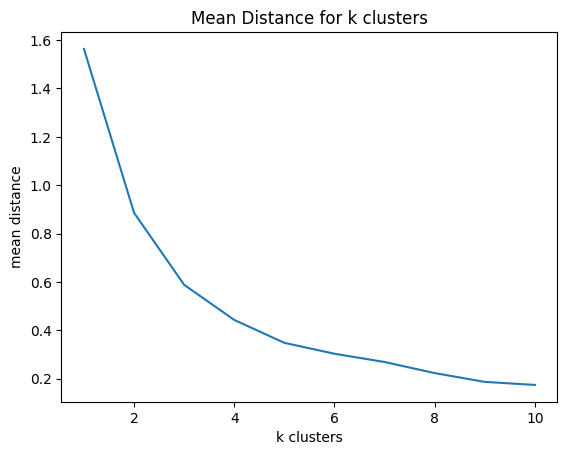

In [25]:
ks = [1,2,3,4,5,6,7,8,9,10]
mean_distances = []

for k in ks:
    p_class_given_data, means, covars, p_class, mean_dist = GMM(dat1, k, 7)
    mean_distances.append(mean_dist)

plt.plot(ks, mean_distances)
plt.xlabel('k clusters')
plt.ylabel('mean distance')
plt.title('Mean Distance for k clusters')

The graph begins to plateau around k=4-6, so this many clusters would work well

In [ ]:
# https://numpy.org/doc/stable/reference/generated/numpy.argmax.html
# import numpy as np
# a = np.arange(6).reshape(2,3) + 10
# a
# array([[10, 11, 12],
#        [13, 14, 15]])
# np.argmax(a)
# 5
# np.argmax(a, axis=0)
# array([1, 1, 1])
# np.argmax(a, axis=1)
# array([2, 2])


def get_top_k_songs(k, pmi, dat, input_song_indices):
    copy_pmi = pmi.copy()
    
    recommendations = []
    probabilities = []

    cluster = 0
    num_clusters = len(copy_pmi[0]) - 1

    while len(recommendations) < k:
        
        if cluster == num_clusters:
            cluster = 0

        highest_indices_from_cluster = np.argmax(copy_pmi, axis=0)

        index = highest_indices_from_cluster[cluster]

        if index not in input_song_indices:
            recommendations.append(index)
            probabilities.append((copy_pmi[index][cluster], cluster))
        copy_pmi[index][cluster] = 0
        cluster += 1

    most_probable_songs = dat.iloc[recommendations].copy()
    most_probable_songs['probability'] = probabilities

    return most_probable_songs

In [44]:
pmi4, mu4, sig4, p4, d4 = GMM(dat1,4,7)
pmi5, mu5, sig5, p5, d5 = GMM(dat1,5,7)
pmi6, mu6, sig6, p6, d6 = GMM(dat1,6,7)
get_top_k_songs(10, pmi4, dat, input_songs_indices)

,id,name,danceability,energy,loudness,speechiness,acousticness,liveness,valence,tempo,probability
384,2GD8Ia7rtJzfgTIy20TaRI,"This Ain't A Scene, It's An Arms Race",0.435,0.887,-4.070,0.0636,0.000747,0.0327,0.408,199.935,"(0.9992831990406575, 1)"
314,7g7M96UGiA7OR79H86gV4m,U And Dat (feat. T. Pain & Kandi Girl),0.858,0.484,-7.448,0.2770,0.024100,0.1230,0.329,99.992,"(0.9999999998767655, 2)"
201,6zsk6uF3MxfIeHPlubKBvR,Get Ur Freak On,0.797,0.750,-9.369,0.2470,0.533000,0.0950,0.740,177.870,"(0.9999999999999911, 0)"
82,5wQnmLuC1W7ATsArWACrgW,Welcome to the Black Parade,0.217,0.905,-4.103,0.0752,0.000289,0.2220,0.236,96.950,"(0.9991916259096224, 1)"
367,20LxTsa6936zOlzTWqoPVt,The Next Episode,0.920,0.891,-2.398,0.2530,0.031300,0.0830,0.311,190.590,"(0.9999999998409701, 2)"
458,72UCrt0G2z6QQkvzEw9dGQ,"Bold as Love - Live at the Nokia Theatre, Los ...",0.385,0.596,-9.027,0.0818,0.050000,0.9660,0.339,104.537,"(0.9999999999999909, 0)"
8,33iv3wnGMrrDugd7GBso1z,My Own Worst Enemy,0.494,0.946,-2.757,0.0637,0.001290,0.3980,0.741,103.408,"(0.9988449987782746, 1)"
69,2ajhenDRiiAnCHHjsIOHhJ,Laffy Taffy,0.891,0.439,-7.994,0.4280,0.035100,0.0932,0.622,77.499,"(0.9999999988494839, 2)"
30,7Lf7oSEVdzZqTA0kEDSlS5,Cry Me a River,0.624,0.653,-6.582,0.1760,0.575000,0.1040,0.565,73.884,"(0.9999999999999026, 0)"
321,7oK9VyNzrYvRFo7nQEYkWN,Mr. Brightside,0.330,0.936,-3.660,0.0917,0.001080,0.0926,0.234,148.112,"(0.9987221847530462, 1)"
